In this notebook, I have tried to depict the following

* Little Bit TS Theory from Wiki , Different Blogposts and Online Books
* EDA
* Seasonality Demonstration
* Moving Average, Exponential Average and Smoothen
* Few Pivot Plots
* Keras Embedding(Re-added for Testing)
* Prophet (With and Without Transformations)
* ARIMA
* Validating The Forecast via Plots and Different Metrics
* Modelling
* LSTM Modelling( Next Update and Probably the last by me...)

We begin with a simple definition of time series:

* Time series is a series of data points indexed (or listed or graphed) in time order. Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.

# Necessary Imports

In [38]:
%matplotlib inline
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)


from fbprophet import Prophet


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [39]:
df_raw = pd.read_csv('train.csv',parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('test.csv', parse_dates=['date'], index_col=['date'])
subs = pd.read_csv('sample_submission.csv')

In [40]:
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [41]:
print("Train and Test shape are {} and {} respectively".format(df_raw.shape, df_test.shape))

Train and Test shape are (913000, 3) and (45000, 3) respectively


In [42]:
df_test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


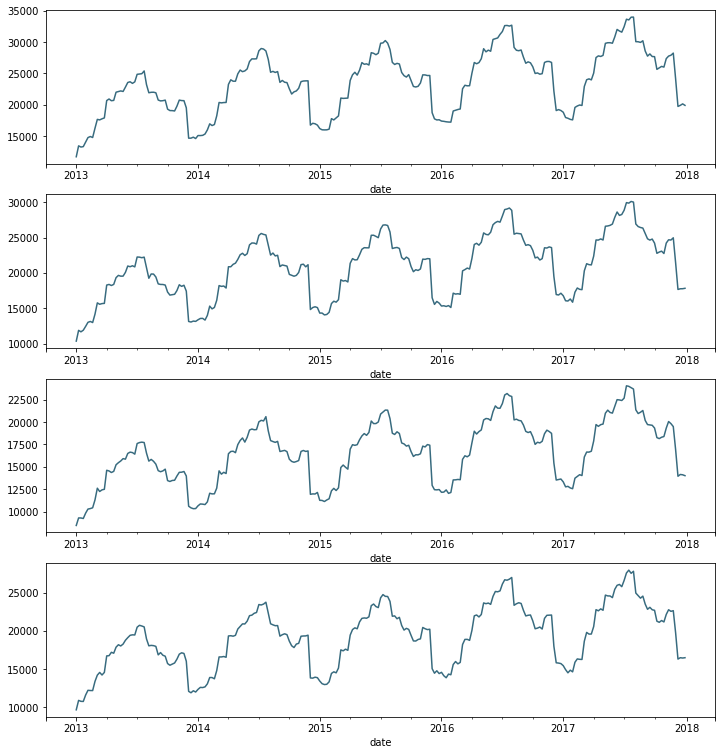

In [43]:
#### Seasonality Check
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0 

# store types
sales_a = df_raw[df_raw.store == 2]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.store == 3]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_raw[df_raw.store == 1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.store == 4]['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

#All Stores have same trend... Weird Seems like the dataset is A Synthetic One..;

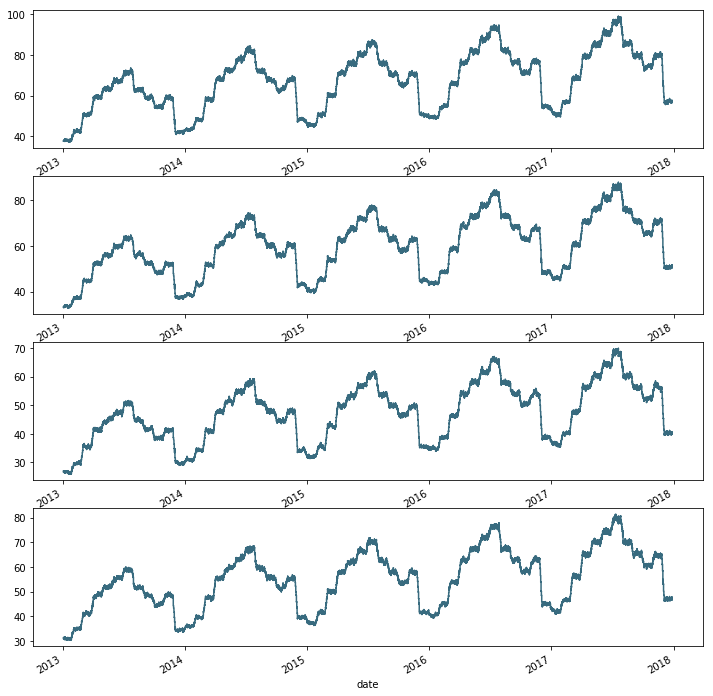

In [44]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Yearly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

In [45]:
date_sales = df_raw.drop(['store', 'item'], axis = 1).copy()

In [46]:
date_sales.get_ftype_counts()

float64:dense    1
dtype: int64

In [47]:
y = date_sales['sales'].resample('MS').mean()
y['2017':]

date
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01    70.974933
2017-07-01    75.573742
2017-08-01    66.219548
2017-09-01    62.350867
2017-10-01    57.494194
2017-11-01    61.922467
2017-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

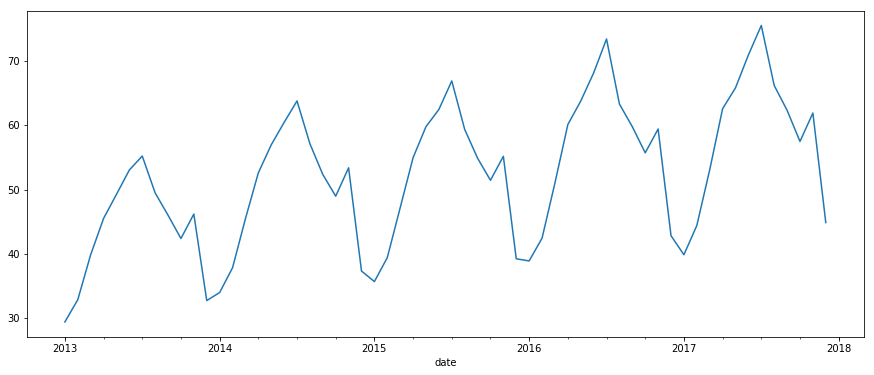

In [48]:
y.plot(figsize=(15, 6),);
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

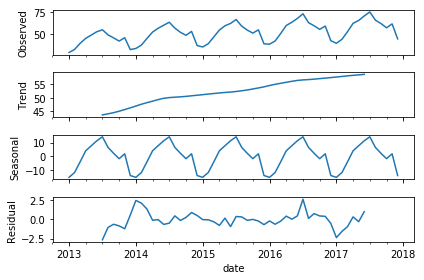

In [49]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;

# Moving Averages

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the moving average.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [50]:
def moving_average(series, n):
    """Calculate average of last n observations"""
    return np.average(series[-n:])
moving_average(date_sales, 24)

64.54166666666667

In [51]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

# Exponential smoothing
Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [52]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [53]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

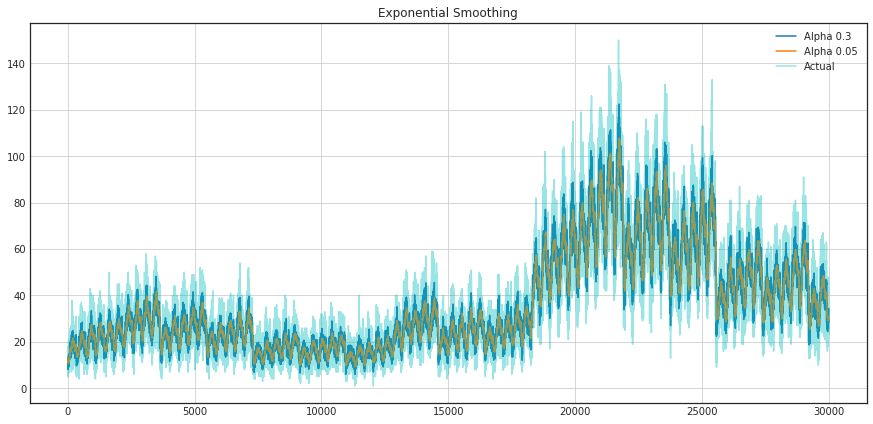

In [54]:
plotExponentialSmoothing(date_sales.sales[:30000], [0.3, 0.05])

Double exponential Smoothing
Up to now, the methods that we've have seen are for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series.
The second term is now split into previous values of the level and of the trend.
The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing.
The final prediction is the sum of the model values of the intercept and trend.

In [55]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.1)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

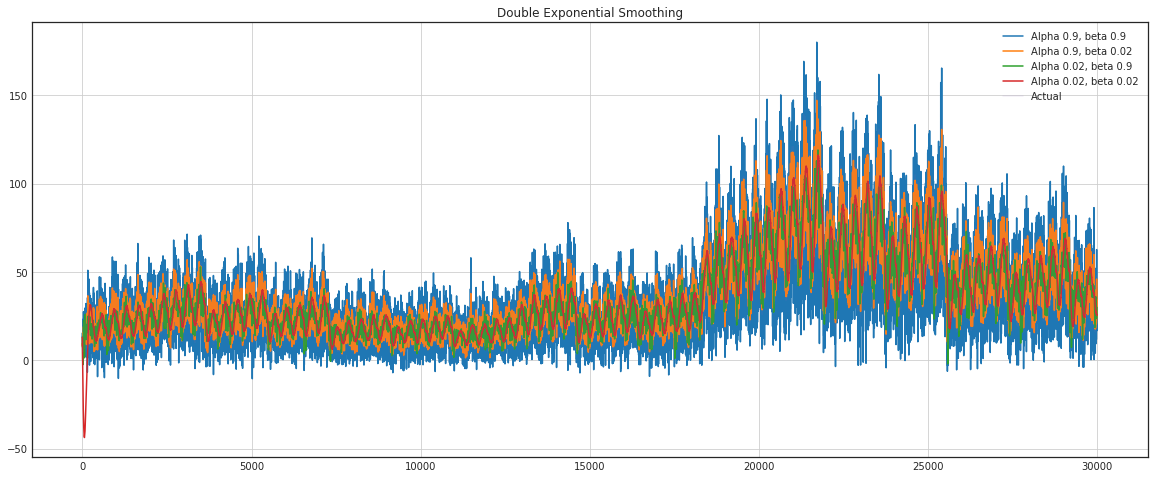

In [56]:
plotDoubleExponentialSmoothing(date_sales.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])

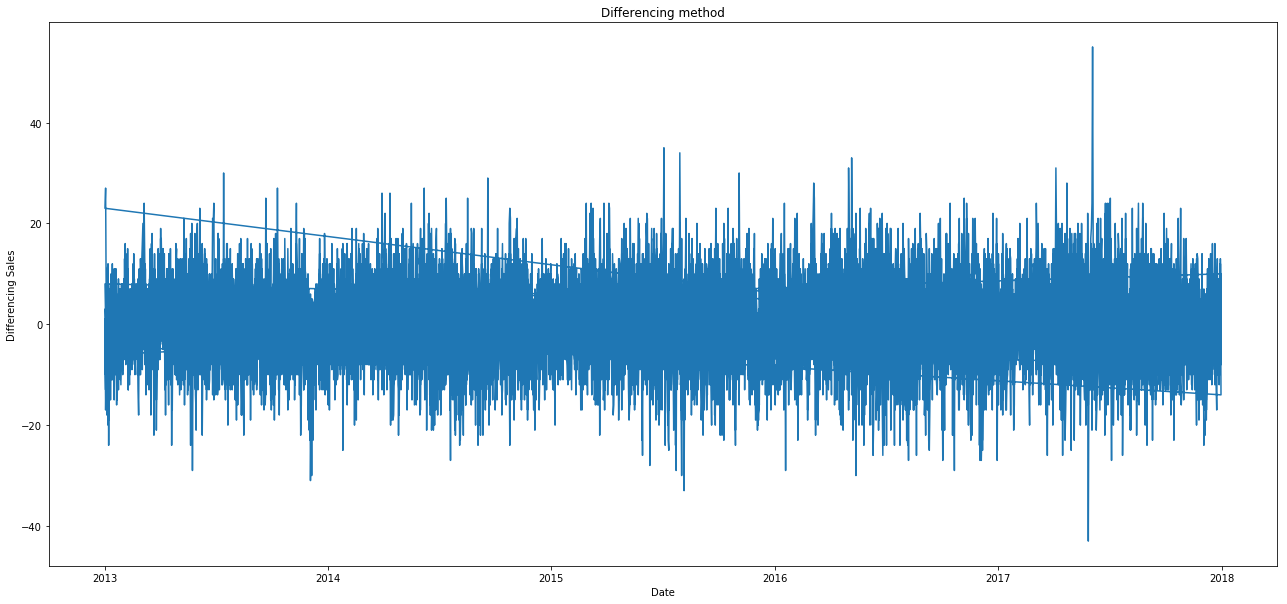

In [57]:
ts_diff = date_sales - date_sales.shift(7)
plt.figure(figsize=(22,10))
plt.plot(ts_diff[:20000])
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Sales");

In [58]:
df_raw = df_raw.reset_index()
df_test = df_test.reset_index()
df_raw.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [59]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'date',False)
add_datepart(df_test,'date',False)

# Few Pivoted Plots

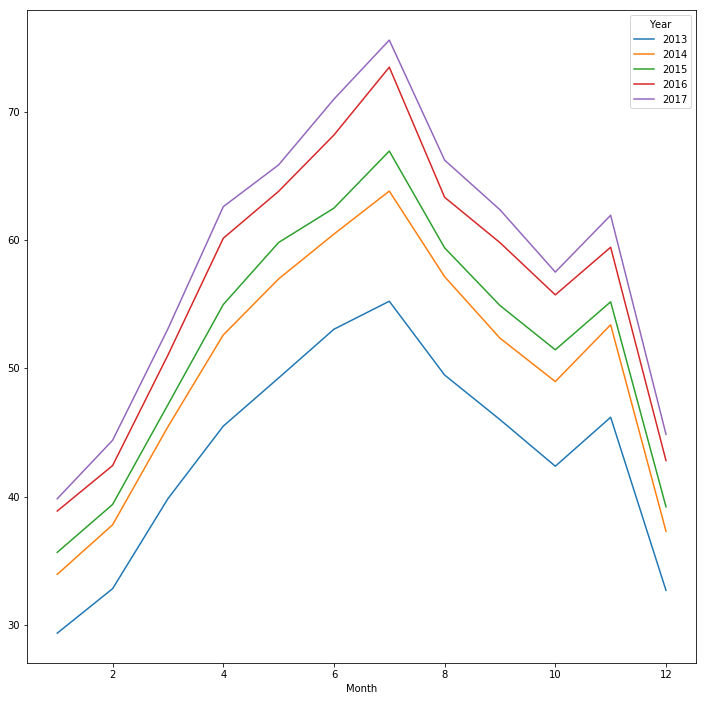

In [60]:
pivoted = pd.pivot_table(df_raw, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

In [61]:
pivoted

Year,2013,2014,2015,2016,2017
Month,,,,,
1,29.348645,33.934645,35.646000,38.867032,39.826194
2,32.815500,37.794071,39.379786,42.410828,44.383500
3,39.831097,45.438774,47.158129,51.024581,53.075290
4,45.484933,52.594267,54.964467,60.130000,62.590800
5,49.241419,56.959806,59.800129,63.789032,65.850710
6,53.039800,60.456133,62.478933,68.177600,70.974933
7,55.220774,63.807097,66.925806,73.465677,75.573742
8,49.468452,57.135226,59.380710,63.322194,66.219548
9,45.993800,52.341600,54.888800,59.788733,62.350867


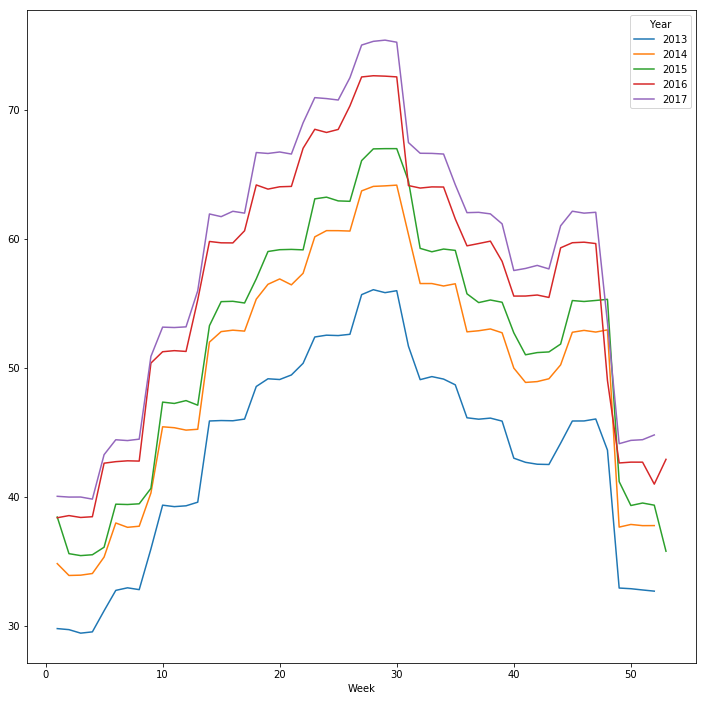

In [62]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

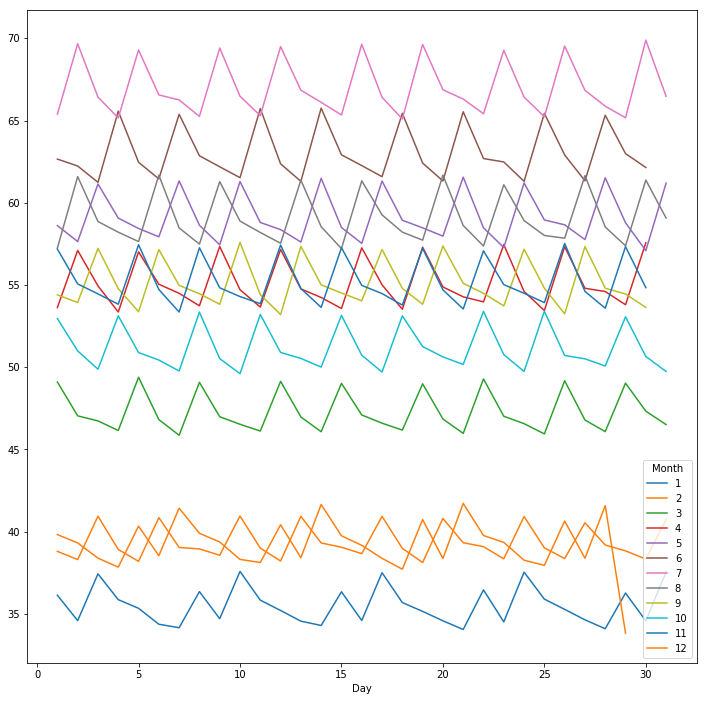

In [63]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

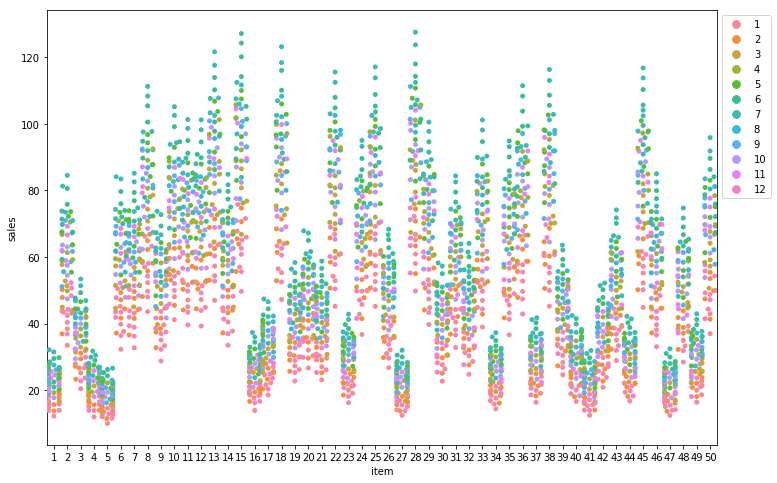

In [64]:
temp_1 = df_raw.groupby(['Year','Month','item'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.swarmplot('item', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2);

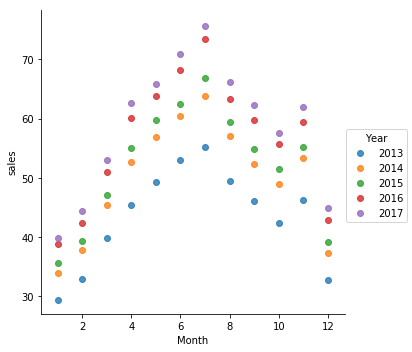

In [65]:
temp_1 = df_raw.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

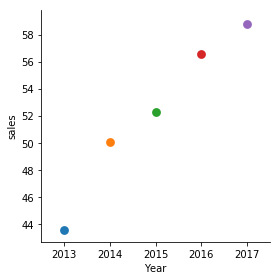

In [66]:
temp_1 = df_raw.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

In [67]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [68]:
original_target = df_raw.sales.values
target, lambda_prophet = stats.boxcox(df_raw['sales'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([df_raw, df_test])

In [69]:
%%time
merged_df["median-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("median")
merged_df["mean-store_item"] = merged_df.groupby(["item", "store"])["sales"].transform("mean")
merged_df["mean-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("mean")
merged_df["median-Month_item"] = merged_df.groupby(["Month", "item"])["sales"].transform("median")
merged_df["median-Month_store"] = merged_df.groupby(["Month", "store"])["sales"].transform("median")
merged_df["median-item"] = merged_df.groupby(["item"])["sales"].transform("median")
merged_df["median-store"] = merged_df.groupby(["store"])["sales"].transform("median")
merged_df["mean-item"] = merged_df.groupby(["item"])["sales"].transform("mean")
merged_df["mean-store"] = merged_df.groupby(["store"])["sales"].transform("mean")

merged_df["median-store_item-Month"] = merged_df.groupby(['Month', "item", "store"])["sales"].transform("median")
merged_df["mean-store_item-week"] = merged_df.groupby(["item", "store",'weekofyear'])["sales"].transform("mean")
merged_df["mean-Month_store"] = merged_df.groupby(['Month', "store"])["sales"].transform("mean")

#adding more lags (Check the rationale behind this in the links attached)

# adding more lags (Check the rationale behind this in the links attached)
lags = [90,91,98,105,112,119,126,182,189,364]
for i in lags:
#     print("Done For Lag {}".format(i))
    merged_df['_'.join(['item-store_shifted-', str(i)])] = merged_df.groupby(['item',"store"])["sales"].transform(lambda x:x.shift(i))  
merged_df["item-week_shifted-90"] = merged_df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(12).mean()) 
merged_df["store-week_shifted-90"] = merged_df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(12).mean())   

Wall time: 7.67 s


In [70]:
df_raw.drop('sales', axis=1, inplace=True)
merged_df.drop(['id','date','sales'], axis=1, inplace=True)
merged_df.head()

,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,item,store,weekofyear,median-store_item,mean-store_item,mean-Month_item,median-Month_item,median-Month_store,median-item,median-store,mean-item,mean-store,median-store_item-Month,mean-store_item-week,mean-Month_store,item-store_shifted-_90,item-store_shifted-_91,item-store_shifted-_98,item-store_shifted-_105,item-store_shifted-_112,item-store_shifted-_119,item-store_shifted-_126,item-store_shifted-_182,item-store_shifted-_189,item-store_shifted-_364,item-week_shifted-90,store-week_shifted-90
0,1,1,1,False,True,False,True,False,True,1,1,2013,1,1,1,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,32.174452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.038235,32.529412
1,2,2,2,False,False,False,False,False,False,1,1,2013,1,1,1,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,32.174452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.038235,32.529412
2,3,3,3,False,False,False,False,False,False,1,1,2013,1,1,1,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,32.174452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.038235,32.529412
3,4,4,4,False,False,False,False,False,False,1,1,2013,1,1,1,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,32.174452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.038235,32.529412
4,5,5,5,False,False,False,False,False,False,1,1,2013,1,1,1,19.0,19.971522,14.830323,14.0,31.0,21.0,44.0,21.981599,47.268379,13.0,13.970588,32.174452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.038235,32.529412


In [71]:
merged_df = merged_df * 1
params = {
    'nthread': 4,
    'categorical_feature' : [0,1,9,10,12,13,14], # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 127,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}

In [72]:
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
    
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)
    
    #train
    gbm = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_train, lgb_valid],
                   early_stopping_rounds=100, verbose_eval=100)
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis = 0)
    
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)
#Don't Forget to apply inverse box-cox

C:\Users\Martin\Anaconda3\lib\site-packages\lightgbm\basic.py:657: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored. Please use categorical_feature argument of the Dataset constructor to pass this parameter.



Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0512365	valid_1's mape: 0.0541059
Early stopping, best iteration is:
[52]	training's mape: 0.0520278	valid_1's mape: 0.0540148
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0512433	valid_1's mape: 0.0539227
Early stopping, best iteration is:
[40]	training's mape: 0.0524758	valid_1's mape: 0.0538167
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0513269	valid_1's mape: 0.0539034
Early stopping, best iteration is:
[42]	training's mape: 0.0524624	valid_1's mape: 0.0538295
Full validation score With Box Cox 0.0530
Inverting Box Cox Transformation
Done!!
Full validation score Re-Box Cox Transformation is 1.4754


In [73]:
importance_df.sort_values(['importance'], ascending=False, inplace=True)
def plot_fi(fi):
    return fi.plot('feature', 'importance', 'barh', figsize=(12,12), legend=False)

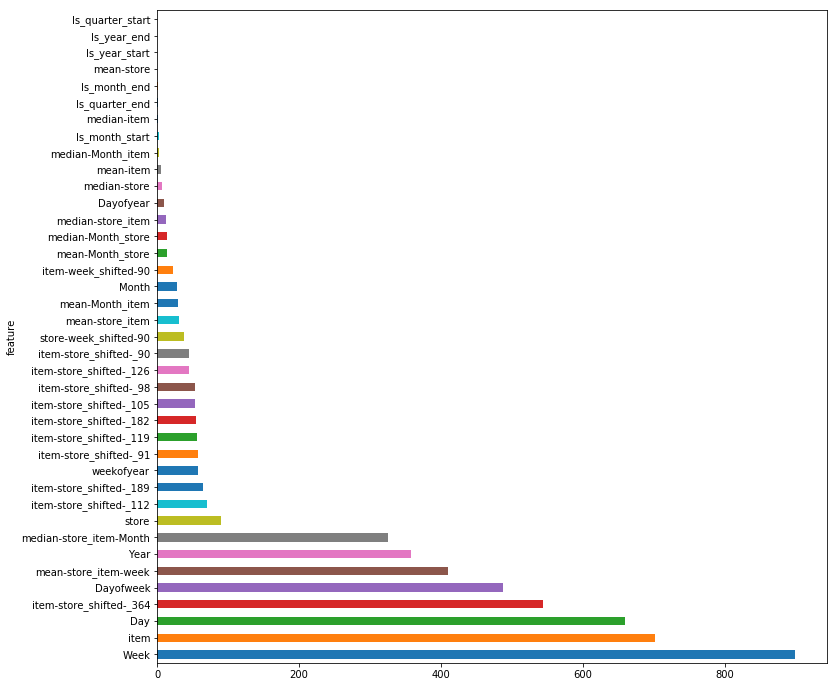

In [74]:
plot_fi(importance_df[:])

In [75]:
merged_df.get_ftype_counts()

float64:dense    24
int64:dense       9
object:dense      6
dtype: int64

In [76]:
# OHE FOR 0,1,9,10,12,13,14  Cols - Day, Dayofweek, Month, Week, item, store, weekofyear
print("Before OHE", merged_df.shape)
merged_df = pd.get_dummies(merged_df, columns=['Day', 'Dayofweek', 'Month', 'Week', 'item', 'store', 'weekofyear'])
print("After OHE", merged_df.shape)
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target;

Before OHE (958000, 39)
After OHE (958000, 248)


In [77]:
def XGB_regressor(train_X, train_y, test_X, test_y= None, feature_names=None, seed_val=2018, num_rounds=500):

    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 4
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

In [78]:
%%time
model = XGB_regressor(train_X = all_x, train_y = all_y, test_X = test_x)
y_test = model.predict(xgb.DMatrix(test_x), ntree_limit = model.best_ntree_limit)

In [79]:
print('Inverting Box Cox Transformation')
y_test = inverse_boxcox(y_test, lambda_prophet) - 1

Inverting Box Cox Transformation


Prophet
(From the Docs Itself)

let's take a closer look at how Prophet works. In its essence, this library utilizes the additive regression model  y(t)  comprising the following components:

y(t)=g(t)+s(t)+h(t)+ϵt,
 
where:

Trend  g(t)  models non-periodic changes.
Seasonality  s(t)  represents periodic changes.
Holidays component  h(t)  contributes information about holidays and events.
Trend  g(t) 
The Prophet library implements two possible trend models for  g(t) .

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:

g(t)=C1+e−k(t−m),
 
where:

C  is the carrying capacity (that is the curve's maximum value).
k  is the growth rate (which represents "the steepness" of the curve).
m  is an offset parameter.
Seasonality  s(t) 
The seasonal component  s(t)  provides a flexible model of periodic changes due to weekly and yearly seasonality. Yearly seasonality model in Prophet relies on Fourier series.

Holidays and Events  h(t) 
The component  h(t)  represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error  ϵ(t) 
The error term  ϵ(t)  represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In describing these time series, we have used words such as  “trend”  and  “seasonal”  which need to be defined more carefully.

Trend

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

Seasonal

A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.

Cycle

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.



# Prophet

In [80]:
df = date_sales.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2013-01-01,13.0
1,2013-01-02,11.0
2,2013-01-03,14.0
3,2013-01-04,13.0
4,2013-01-05,10.0


In [81]:
df['store'] = df_raw['store'].copy()
df['Week'] = df_raw['Week'].copy()
df['item'] = df_raw['item'].copy()

In [82]:
df = df.query('item == 1 & store == 1')

In [83]:
df.groupby(['Week', 'store', 'item'])['y'].mean().reset_index().head()

,Week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857


* The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data. Luckily, in our case we have more than a couple of years of data to fit the model.

* To measure the quality of our forecast, we need to split our dataset into the historical part and the prediction part... (we should have done this)

In [84]:
prediction_size = 31
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y,store,Week,item
1792,2017-11-28,14.0,1,48,1
1793,2017-11-29,28.0,1,48,1
1794,2017-11-30,15.0,1,48,1


Now we need to create a new Prophet object. Here we can pass the parameters of the model into the constructor. But currently we will use the defualts as it is. Then we train our model by invoking its fit method on our training dataset.

In [85]:
%%time
m = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Martin\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Wall time: 847 ms


Using the helper method Prophet.make_future_dataframe, we create a dataframe which will contain all dates from the history and also extend into the future for those 92 days that we left out before.

In [87]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


We predict values with Prophet by passing in the dates for which we want to create a forecast. If we also supply the historical dates (as in our case), then in addition to the prediction we will get an in-sample fit for the history. Let's call the model's predict method with our future dataframe as an input:

In [88]:
%%time
forecast = m.predict(future)
forecast.tail(n=3)

Wall time: 5.74 s


In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

First, there is a method called Prophet.plot that plots all the points from the forecast:
The Second function Prophet.plot_components might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.

In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

First, there is a method called Prophet.plot that plots all the points from the forecast:
The Second function Prophet.plot_components might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.

Let's try it out:

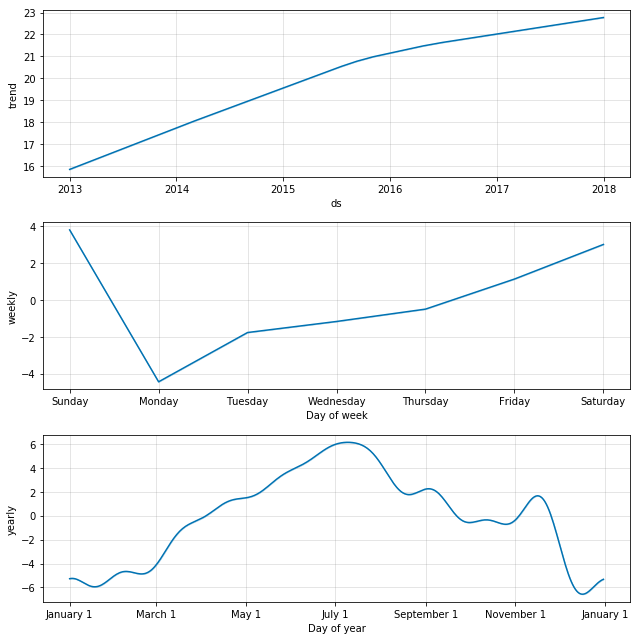

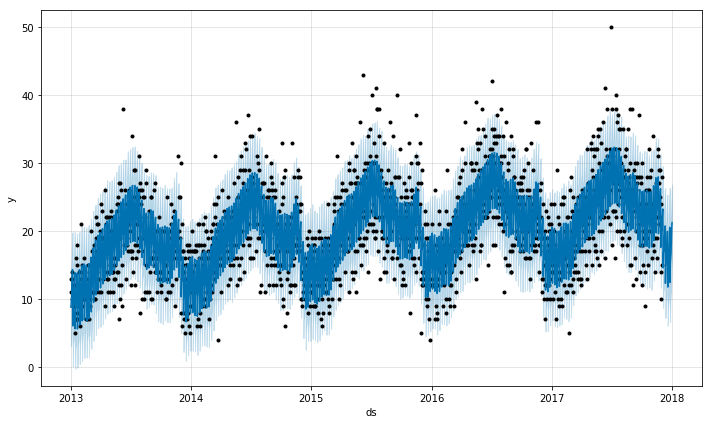

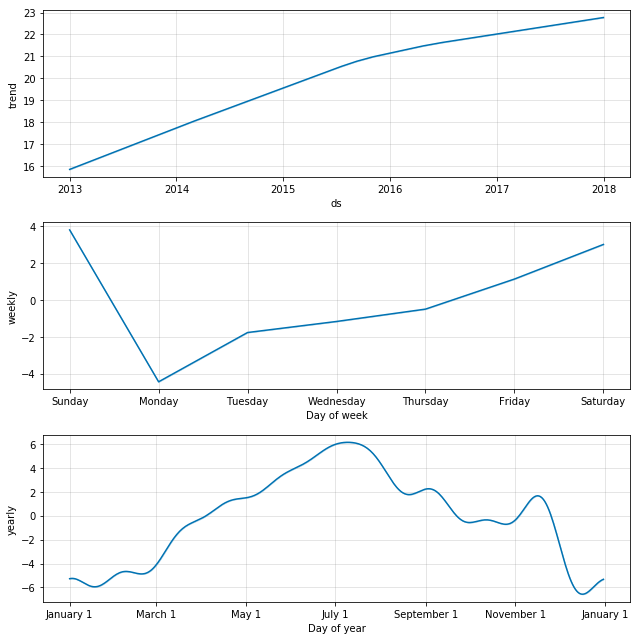

In [90]:
m.plot(forecast)
m.plot_components(forecast)

The last Weekly Plot Says it All.

* Seems like People go to Shopping Mostly in July
* Have a look at the peak at Sundays and Saturdays (3rd Plot)
* So we should add the holidays effect to make Prohet perform better.

In [100]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [101]:
%%time
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']])

C:\Users\Martin\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Wall time: 1.15 s


In [102]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


The holiday effect can be seen in the forecast dataframe:

In [103]:
%%time
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

TypeError: concat() got an unexpected keyword argument 'sort'

# Basic ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data..

* AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
* I: Integrated (d): These are the number of nonseasonal differences. For example, in our case we take the first order difference. So we pass that variable and put d=0
* MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [118]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


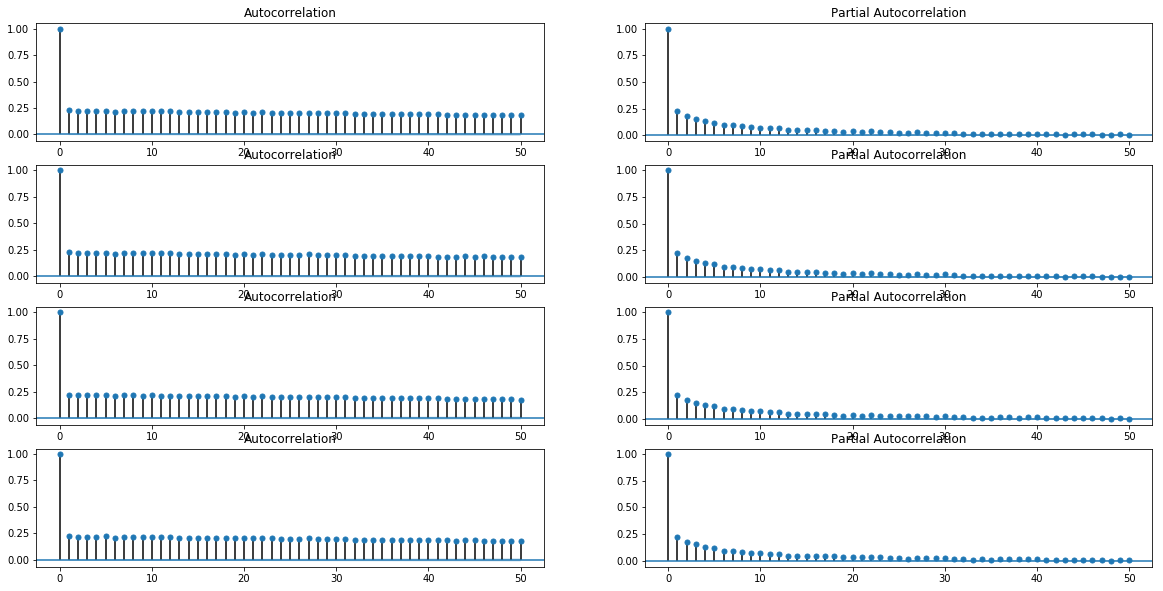

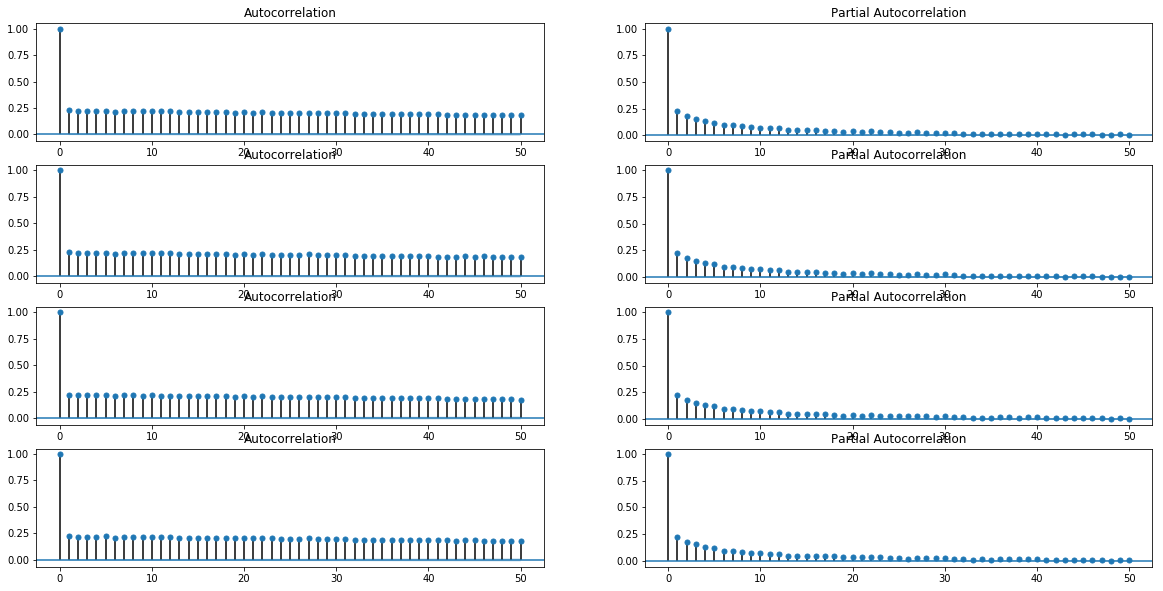

In [136]:
# figure for subplots
plt.figure(figsize = (12,8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
fig, ax = plt.subplots(4,2, figsize=(20,10))
plot_acf(sales_a, lags = 50, ax = ax[0,0])
plot_pacf(sales_a, lags = 50, ax = ax[0,1])
plot_acf(sales_b, lags = 50, ax = ax[1,0])
plot_pacf(sales_b, lags = 50, ax = ax[1,1])
plot_acf(sales_c, lags = 50, ax = ax[2,0])
plot_pacf(sales_c, lags = 50, ax = ax[2,1])
plot_acf(sales_d, lags = 50, ax = ax[3,0])
plot_pacf(sales_d, lags = 50, ax = ax[3,1])

From the above we can see that the lags till 50 are having weightage wrt the ACF Plots, but according to the PACF plots they valley out after the 10th lag...

In [142]:
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enfore_stationary=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}X{} 12 - AI C:{}'.format(cnt,param,param_seasonal, results.aic))
        except:
            continue

Current Iter - 1, ARIMA(0, 0, 0)X(0, 0, 1, 12) 12 - AI C:599.4857299436735
Current Iter - 2, ARIMA(0, 0, 0)X(0, 1, 1, 12) 12 - AI C:2027.3226336388889


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 3, ARIMA(0, 0, 0)X(1, 1, 0, 12) 12 - AI C:256.8397396876189


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 4, ARIMA(0, 0, 0)X(1, 1, 1, 12) 12 - AI C:1794.4610724579657
Current Iter - 5, ARIMA(0, 0, 0)X(1, 2, 0, 12) 12 - AI C:160.18756841619415
Current Iter - 6, ARIMA(0, 0, 0)X(2, 1, 0, 12) 12 - AI C:229.04314727053293


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 7, ARIMA(0, 0, 0)X(2, 1, 1, 12) 12 - AI C:1477.2495098001873
Current Iter - 8, ARIMA(0, 0, 0)X(2, 2, 0, 12) 12 - AI C:161.72466633931523
Current Iter - 9, ARIMA(0, 0, 1)X(0, 0, 0, 12) 12 - AI C:582.5398698590295


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 10, ARIMA(0, 0, 1)X(0, 0, 1, 12) 12 - AI C:659.9810851764547
Current Iter - 11, ARIMA(0, 0, 1)X(0, 1, 0, 12) 12 - AI C:227.70916998647846
Current Iter - 12, ARIMA(0, 0, 1)X(0, 1, 1, 12) 12 - AI C:2040.9646841158683
Current Iter - 13, ARIMA(0, 0, 1)X(0, 2, 0, 12) 12 - AI C:158.82593408109278
Current Iter - 14, ARIMA(0, 0, 1)X(1, 1, 0, 12) 12 - AI C:212.53407191254135


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 15, ARIMA(0, 0, 1)X(1, 1, 1, 12) 12 - AI C:1555.7957223884523
Current Iter - 16, ARIMA(0, 0, 1)X(1, 2, 0, 12) 12 - AI C:141.39837438726627
Current Iter - 17, ARIMA(0, 0, 1)X(2, 1, 0, 12) 12 - AI C:197.76606315539732
Current Iter - 18, ARIMA(0, 0, 1)X(2, 1, 1, 12) 12 - AI C:1462.4673966709797
Current Iter - 19, ARIMA(0, 0, 1)X(2, 2, 0, 12) 12 - AI C:143.05538025279986
Current Iter - 20, ARIMA(0, 0, 2)X(0, 0, 0, 12) 12 - AI C:520.778599956842


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 21, ARIMA(0, 0, 2)X(0, 0, 1, 12) 12 - AI C:595.2359832719013
Current Iter - 22, ARIMA(0, 0, 2)X(0, 1, 0, 12) 12 - AI C:207.25897849802212


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 23, ARIMA(0, 0, 2)X(0, 1, 1, 12) 12 - AI C:1809.6480232419847
Current Iter - 24, ARIMA(0, 0, 2)X(0, 2, 0, 12) 12 - AI C:153.2857821614287
Current Iter - 25, ARIMA(0, 0, 2)X(1, 1, 0, 12) 12 - AI C:198.60673496337384


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 26, ARIMA(0, 0, 2)X(1, 1, 1, 12) 12 - AI C:1610.4997384547928
Current Iter - 27, ARIMA(0, 0, 2)X(1, 2, 0, 12) 12 - AI C:139.89123854182924
Current Iter - 28, ARIMA(0, 0, 2)X(2, 1, 0, 12) 12 - AI C:191.10444306222973


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 29, ARIMA(0, 0, 2)X(2, 1, 1, 12) 12 - AI C:1425.9467375850963
Current Iter - 30, ARIMA(0, 0, 2)X(2, 2, 0, 12) 12 - AI C:141.93031905638006
Current Iter - 31, ARIMA(0, 1, 0)X(0, 0, 1, 12) 12 - AI C:348.87179220113745


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 32, ARIMA(0, 1, 0)X(0, 1, 1, 12) 12 - AI C:1946.7805423484242
Current Iter - 33, ARIMA(0, 1, 0)X(1, 1, 0, 12) 12 - AI C:145.29583828078938


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 34, ARIMA(0, 1, 0)X(1, 1, 1, 12) 12 - AI C:1959.50638567239
Current Iter - 35, ARIMA(0, 1, 0)X(1, 2, 0, 12) 12 - AI C:120.68366437814528
Current Iter - 36, ARIMA(0, 1, 0)X(2, 1, 0, 12) 12 - AI C:143.99263345825435


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 37, ARIMA(0, 1, 0)X(2, 1, 1, 12) 12 - AI C:2262.8422462268077
Current Iter - 38, ARIMA(0, 1, 0)X(2, 2, 0, 12) 12 - AI C:121.55780567891358
Current Iter - 39, ARIMA(0, 1, 1)X(0, 0, 0, 12) 12 - AI C:397.5180470471773
Current Iter - 40, ARIMA(0, 1, 1)X(0, 0, 1, 12) 12 - AI C:349.2442046745071
Current Iter - 41, ARIMA(0, 1, 1)X(0, 1, 0, 12) 12 - AI C:145.14890507630685


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 42, ARIMA(0, 1, 1)X(0, 1, 1, 12) 12 - AI C:1799.3156791223478
Current Iter - 43, ARIMA(0, 1, 1)X(0, 2, 0, 12) 12 - AI C:132.4704064943051
Current Iter - 44, ARIMA(0, 1, 1)X(1, 1, 0, 12) 12 - AI C:146.98883187058954


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 45, ARIMA(0, 1, 1)X(1, 1, 1, 12) 12 - AI C:1814.9867088615802
Current Iter - 46, ARIMA(0, 1, 1)X(1, 2, 0, 12) 12 - AI C:118.05498878634258
Current Iter - 47, ARIMA(0, 1, 1)X(2, 1, 0, 12) 12 - AI C:143.4081946466164


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 48, ARIMA(0, 1, 1)X(2, 1, 1, 12) 12 - AI C:1992.2616698027032
Current Iter - 49, ARIMA(0, 1, 1)X(2, 2, 0, 12) 12 - AI C:119.63986881675555
Current Iter - 51, ARIMA(0, 1, 2)X(0, 0, 1, 12) 12 - AI C:349.8093476352781
Current Iter - 52, ARIMA(0, 1, 2)X(0, 1, 0, 12) 12 - AI C:147.04577452666896
Current Iter - 53, ARIMA(0, 1, 2)X(0, 1, 1, 12) 12 - AI C:2017.1216396297232
Current Iter - 54, ARIMA(0, 1, 2)X(0, 2, 0, 12) 12 - AI C:134.15273839730236
Current Iter - 55, ARIMA(0, 1, 2)X(1, 1, 0, 12) 12 - AI C:148.93020211664893
Current Iter - 56, ARIMA(0, 1, 2)X(1, 1, 1, 12) 12 - AI C:2032.8071041377418
Current Iter - 57, ARIMA(0, 1, 2)X(1, 2, 0, 12) 12 - AI C:118.44082459214944
Current Iter - 58, ARIMA(0, 1, 2)X(2, 1, 0, 12) 12 - AI C:144.89834048039518


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 59, ARIMA(0, 1, 2)X(2, 1, 1, 12) 12 - AI C:1684.3997462590544
Current Iter - 60, ARIMA(0, 1, 2)X(2, 2, 0, 12) 12 - AI C:120.28569990560291
Current Iter - 61, ARIMA(0, 2, 0)X(0, 0, 1, 12) 12 - AI C:369.36962612946587


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 62, ARIMA(0, 2, 0)X(0, 1, 1, 12) 12 - AI C:1305.1247687126108
Current Iter - 63, ARIMA(0, 2, 0)X(1, 1, 0, 12) 12 - AI C:178.3810226025437


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 64, ARIMA(0, 2, 0)X(1, 1, 1, 12) 12 - AI C:2138.269082906338
Current Iter - 65, ARIMA(0, 2, 0)X(1, 2, 0, 12) 12 - AI C:150.37863974602385
Current Iter - 66, ARIMA(0, 2, 0)X(2, 1, 0, 12) 12 - AI C:180.19545306414926
Current Iter - 67, ARIMA(0, 2, 0)X(2, 2, 0, 12) 12 - AI C:149.93315125447782
Current Iter - 68, ARIMA(0, 2, 1)X(0, 0, 0, 12) 12 - AI C:397.40652350026295
Current Iter - 69, ARIMA(0, 2, 1)X(0, 0, 1, 12) 12 - AI C:349.1595002017082
Current Iter - 70, ARIMA(0, 2, 1)X(0, 1, 0, 12) 12 - AI C:147.14431439999316


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 71, ARIMA(0, 2, 1)X(0, 1, 1, 12) 12 - AI C:1729.4344952989022
Current Iter - 72, ARIMA(0, 2, 1)X(0, 2, 0, 12) 12 - AI C:133.96594693835746
Current Iter - 73, ARIMA(0, 2, 1)X(1, 1, 0, 12) 12 - AI C:149.09898122283963
Current Iter - 74, ARIMA(0, 2, 1)X(1, 1, 1, 12) 12 - AI C:1838.857786312216
Current Iter - 75, ARIMA(0, 2, 1)X(1, 2, 0, 12) 12 - AI C:124.76367390439356
Current Iter - 76, ARIMA(0, 2, 1)X(2, 1, 0, 12) 12 - AI C:147.56763947827122
Current Iter - 77, ARIMA(0, 2, 1)X(2, 2, 0, 12) 12 - AI C:125.91267384452165
Current Iter - 78, ARIMA(0, 2, 2)X(0, 0, 0, 12) 12 - AI C:397.5891426218396
Current Iter - 79, ARIMA(0, 2, 2)X(0, 0, 1, 12) 12 - AI C:349.31590974014773
Current Iter - 80, ARIMA(0, 2, 2)X(0, 1, 0, 12) 12 - AI C:148.9937800658124


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 81, ARIMA(0, 2, 2)X(0, 1, 1, 12) 12 - AI C:1815.0645728221025
Current Iter - 82, ARIMA(0, 2, 2)X(0, 2, 0, 12) 12 - AI C:135.5801833396433
Current Iter - 83, ARIMA(0, 2, 2)X(1, 1, 0, 12) 12 - AI C:150.93695249033567


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 84, ARIMA(0, 2, 2)X(1, 1, 1, 12) 12 - AI C:1835.4695858001041
Current Iter - 85, ARIMA(0, 2, 2)X(1, 2, 0, 12) 12 - AI C:121.58130810408569
Current Iter - 86, ARIMA(0, 2, 2)X(2, 1, 0, 12) 12 - AI C:147.43318265313698
Current Iter - 87, ARIMA(0, 2, 2)X(2, 2, 0, 12) 12 - AI C:123.24434971858702
Current Iter - 88, ARIMA(1, 0, 0)X(0, 0, 0, 12) 12 - AI C:409.07772697294143


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 89, ARIMA(1, 0, 0)X(0, 0, 1, 12) 12 - AI C:360.7133396720777
Current Iter - 90, ARIMA(1, 0, 0)X(0, 1, 0, 12) 12 - AI C:150.09338951579173


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 91, ARIMA(1, 0, 0)X(0, 1, 1, 12) 12 - AI C:2258.0015712508075
Current Iter - 92, ARIMA(1, 0, 0)X(0, 2, 0, 12) 12 - AI C:135.76939998380465
Current Iter - 93, ARIMA(1, 0, 0)X(1, 1, 0, 12) 12 - AI C:151.99559944629593


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 94, ARIMA(1, 0, 0)X(1, 1, 1, 12) 12 - AI C:1825.9259828405193
Current Iter - 95, ARIMA(1, 0, 0)X(1, 2, 0, 12) 12 - AI C:123.23722662563802
Current Iter - 96, ARIMA(1, 0, 0)X(2, 1, 0, 12) 12 - AI C:150.15580343688


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 97, ARIMA(1, 0, 0)X(2, 1, 1, 12) 12 - AI C:1508.1805072890809
Current Iter - 98, ARIMA(1, 0, 0)X(2, 2, 0, 12) 12 - AI C:124.76107339042501
Current Iter - 99, ARIMA(1, 0, 1)X(0, 0, 0, 12) 12 - AI C:409.3536236044216


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 101, ARIMA(1, 0, 1)X(0, 1, 0, 12) 12 - AI C:151.93123931825528


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 102, ARIMA(1, 0, 1)X(0, 1, 1, 12) 12 - AI C:1756.7618656770637
Current Iter - 103, ARIMA(1, 0, 1)X(0, 2, 0, 12) 12 - AI C:137.57973485942443
Current Iter - 104, ARIMA(1, 0, 1)X(1, 1, 0, 12) 12 - AI C:153.80347169748356
Current Iter - 105, ARIMA(1, 0, 1)X(1, 1, 1, 12) 12 - AI C:1610.7691445033722
Current Iter - 106, ARIMA(1, 0, 1)X(1, 2, 0, 12) 12 - AI C:121.79616770600792
Current Iter - 107, ARIMA(1, 0, 1)X(2, 1, 0, 12) 12 - AI C:149.99750378814196


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 108, ARIMA(1, 0, 1)X(2, 1, 1, 12) 12 - AI C:757.2799531030716
Current Iter - 109, ARIMA(1, 0, 1)X(2, 2, 0, 12) 12 - AI C:123.43962445273452
Current Iter - 110, ARIMA(1, 0, 2)X(0, 0, 0, 12) 12 - AI C:409.64616573984125


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 111, ARIMA(1, 0, 2)X(0, 0, 1, 12) 12 - AI C:411.91989725048404
Current Iter - 112, ARIMA(1, 0, 2)X(0, 1, 0, 12) 12 - AI C:153.88113629510121


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 113, ARIMA(1, 0, 2)X(0, 1, 1, 12) 12 - AI C:2139.4807358244743
Current Iter - 114, ARIMA(1, 0, 2)X(0, 2, 0, 12) 12 - AI C:139.39811706688278
Current Iter - 115, ARIMA(1, 0, 2)X(1, 1, 0, 12) 12 - AI C:155.77857507142758


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 116, ARIMA(1, 0, 2)X(1, 1, 1, 12) 12 - AI C:1485.2469591954546
Current Iter - 117, ARIMA(1, 0, 2)X(1, 2, 0, 12) 12 - AI C:121.81432920180505
Current Iter - 118, ARIMA(1, 0, 2)X(2, 1, 0, 12) 12 - AI C:151.16753463876844
Current Iter - 119, ARIMA(1, 0, 2)X(2, 1, 1, 12) 12 - AI C:1520.45147125161
Current Iter - 120, ARIMA(1, 0, 2)X(2, 2, 0, 12) 12 - AI C:123.69263043269807
Current Iter - 121, ARIMA(1, 1, 0)X(0, 0, 0, 12) 12 - AI C:397.0219185188452
Current Iter - 122, ARIMA(1, 1, 0)X(0, 0, 1, 12) 12 - AI C:348.7776651548623
Current Iter - 123, ARIMA(1, 1, 0)X(0, 1, 0, 12) 12 - AI C:145.1788331109693


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 124, ARIMA(1, 1, 0)X(0, 1, 1, 12) 12 - AI C:1986.9857997991085
Current Iter - 125, ARIMA(1, 1, 0)X(0, 2, 0, 12) 12 - AI C:132.61353774970024
Current Iter - 126, ARIMA(1, 1, 0)X(1, 1, 0, 12) 12 - AI C:147.0162859756342


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 127, ARIMA(1, 1, 0)X(1, 1, 1, 12) 12 - AI C:2002.6711149697883
Current Iter - 128, ARIMA(1, 1, 0)X(1, 2, 0, 12) 12 - AI C:118.37837008442168
Current Iter - 129, ARIMA(1, 1, 0)X(2, 1, 0, 12) 12 - AI C:143.5052873664001


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 130, ARIMA(1, 1, 0)X(2, 1, 1, 12) 12 - AI C:1990.8919477395016
Current Iter - 131, ARIMA(1, 1, 0)X(2, 2, 0, 12) 12 - AI C:119.95928945289486
Current Iter - 132, ARIMA(1, 1, 1)X(0, 0, 0, 12) 12 - AI C:398.7292464497046
Current Iter - 133, ARIMA(1, 1, 1)X(0, 0, 1, 12) 12 - AI C:350.53011631234176
Current Iter - 134, ARIMA(1, 1, 1)X(0, 1, 0, 12) 12 - AI C:145.70228884832272


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 135, ARIMA(1, 1, 1)X(0, 1, 1, 12) 12 - AI C:1869.3027822242184
Current Iter - 136, ARIMA(1, 1, 1)X(0, 2, 0, 12) 12 - AI C:134.4450863208827
Current Iter - 137, ARIMA(1, 1, 1)X(1, 1, 0, 12) 12 - AI C:147.68000235632937


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 138, ARIMA(1, 1, 1)X(1, 1, 1, 12) 12 - AI C:1885.0950815321282
Current Iter - 139, ARIMA(1, 1, 1)X(1, 2, 0, 12) 12 - AI C:124.66523566197314
Current Iter - 140, ARIMA(1, 1, 1)X(2, 1, 0, 12) 12 - AI C:146.84192234198585
Current Iter - 141, ARIMA(1, 1, 1)X(2, 1, 1, 12) 12 - AI C:1996.653166905585
Current Iter - 142, ARIMA(1, 1, 1)X(2, 2, 0, 12) 12 - AI C:125.55629658536972
Current Iter - 143, ARIMA(1, 1, 2)X(0, 0, 0, 12) 12 - AI C:392.78889186286926
Current Iter - 144, ARIMA(1, 1, 2)X(0, 0, 1, 12) 12 - AI C:345.17819152879997
Current Iter - 145, ARIMA(1, 1, 2)X(0, 1, 0, 12) 12 - AI C:146.8139675165287


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 146, ARIMA(1, 1, 2)X(0, 1, 1, 12) 12 - AI C:1695.4861016733478
Current Iter - 147, ARIMA(1, 1, 2)X(0, 2, 0, 12) 12 - AI C:134.43085319759462
Current Iter - 148, ARIMA(1, 1, 2)X(1, 1, 0, 12) 12 - AI C:148.78636741045466


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 149, ARIMA(1, 1, 2)X(1, 1, 1, 12) 12 - AI C:1956.0635710558079
Current Iter - 151, ARIMA(1, 1, 2)X(2, 1, 0, 12) 12 - AI C:145.52655959139815
Current Iter - 152, ARIMA(1, 1, 2)X(2, 1, 1, 12) 12 - AI C:2010.6623062873673
Current Iter - 153, ARIMA(1, 1, 2)X(2, 2, 0, 12) 12 - AI C:123.13815789110805
Current Iter - 154, ARIMA(1, 2, 0)X(0, 0, 0, 12) 12 - AI C:405.0565543996214
Current Iter - 155, ARIMA(1, 2, 0)X(0, 0, 1, 12) 12 - AI C:358.2224070022727
Current Iter - 156, ARIMA(1, 2, 0)X(0, 1, 0, 12) 12 - AI C:165.21001031159653


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 157, ARIMA(1, 2, 0)X(0, 1, 1, 12) 12 - AI C:1732.944873707031
Current Iter - 158, ARIMA(1, 2, 0)X(0, 2, 0, 12) 12 - AI C:148.78569988356708
Current Iter - 159, ARIMA(1, 2, 0)X(1, 1, 0, 12) 12 - AI C:166.81095345911427


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 160, ARIMA(1, 2, 0)X(1, 1, 1, 12) 12 - AI C:1739.025959412706
Current Iter - 161, ARIMA(1, 2, 0)X(1, 2, 0, 12) 12 - AI C:139.22129496280292
Current Iter - 162, ARIMA(1, 2, 0)X(2, 1, 0, 12) 12 - AI C:166.69321867737048
Current Iter - 163, ARIMA(1, 2, 0)X(2, 2, 0, 12) 12 - AI C:139.95224739962458
Current Iter - 164, ARIMA(1, 2, 1)X(0, 0, 0, 12) 12 - AI C:396.9442337504523
Current Iter - 165, ARIMA(1, 2, 1)X(0, 0, 1, 12) 12 - AI C:348.7067419205221
Current Iter - 166, ARIMA(1, 2, 1)X(0, 1, 0, 12) 12 - AI C:149.0064425688647


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 167, ARIMA(1, 2, 1)X(0, 1, 1, 12) 12 - AI C:1811.5391789199246
Current Iter - 168, ARIMA(1, 2, 1)X(0, 2, 0, 12) 12 - AI C:135.65258787270747
Current Iter - 169, ARIMA(1, 2, 1)X(1, 1, 0, 12) 12 - AI C:150.94868381431618


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 170, ARIMA(1, 2, 1)X(1, 1, 1, 12) 12 - AI C:1812.6101351540885
Current Iter - 171, ARIMA(1, 2, 1)X(1, 2, 0, 12) 12 - AI C:123.22546356622843
Current Iter - 172, ARIMA(1, 2, 1)X(2, 1, 0, 12) 12 - AI C:147.43970567567686
Current Iter - 173, ARIMA(1, 2, 1)X(2, 2, 0, 12) 12 - AI C:124.9596781553567


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 174, ARIMA(1, 2, 2)X(0, 0, 0, 12) 12 - AI C:397.4696922437209


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 175, ARIMA(1, 2, 2)X(0, 0, 1, 12) 12 - AI C:349.5022928786638
Current Iter - 176, ARIMA(1, 2, 2)X(0, 1, 0, 12) 12 - AI C:149.35982787467196


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 177, ARIMA(1, 2, 2)X(0, 1, 1, 12) 12 - AI C:1613.3268858411423
Current Iter - 178, ARIMA(1, 2, 2)X(0, 2, 0, 12) 12 - AI C:137.17692411927482
Current Iter - 179, ARIMA(1, 2, 2)X(1, 1, 0, 12) 12 - AI C:151.35982779520103


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 180, ARIMA(1, 2, 2)X(1, 1, 1, 12) 12 - AI C:1837.1783104641074
Current Iter - 181, ARIMA(1, 2, 2)X(1, 2, 0, 12) 12 - AI C:124.68366665200084
Current Iter - 182, ARIMA(1, 2, 2)X(2, 1, 0, 12) 12 - AI C:150.33968537430715
Current Iter - 183, ARIMA(1, 2, 2)X(2, 2, 0, 12) 12 - AI C:125.24376693977293
Current Iter - 184, ARIMA(2, 0, 0)X(0, 0, 0, 12) 12 - AI C:408.77124689374176


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 185, ARIMA(2, 0, 0)X(0, 0, 1, 12) 12 - AI C:374.2134575159991
Current Iter - 186, ARIMA(2, 0, 0)X(0, 1, 0, 12) 12 - AI C:151.94496260980955


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 187, ARIMA(2, 0, 0)X(0, 1, 1, 12) 12 - AI C:2022.3044732363542
Current Iter - 188, ARIMA(2, 0, 0)X(0, 2, 0, 12) 12 - AI C:137.61340974527414
Current Iter - 189, ARIMA(2, 0, 0)X(1, 1, 0, 12) 12 - AI C:153.81690461132712
Current Iter - 190, ARIMA(2, 0, 0)X(1, 1, 1, 12) 12 - AI C:1214.5423674183885
Current Iter - 191, ARIMA(2, 0, 0)X(1, 2, 0, 12) 12 - AI C:121.86292486349018
Current Iter - 192, ARIMA(2, 0, 0)X(2, 1, 0, 12) 12 - AI C:149.9767379742919


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 193, ARIMA(2, 0, 0)X(2, 1, 1, 12) 12 - AI C:1412.7472704034963
Current Iter - 194, ARIMA(2, 0, 0)X(2, 2, 0, 12) 12 - AI C:123.5491531484995
Current Iter - 195, ARIMA(2, 0, 1)X(0, 0, 0, 12) 12 - AI C:410.3884000233345


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 196, ARIMA(2, 0, 1)X(0, 0, 1, 12) 12 - AI C:410.2312315233486
Current Iter - 197, ARIMA(2, 0, 1)X(0, 1, 0, 12) 12 - AI C:153.18725054949837


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 198, ARIMA(2, 0, 1)X(0, 1, 1, 12) 12 - AI C:1853.1992889614578


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 199, ARIMA(2, 0, 1)X(1, 1, 0, 12) 12 - AI C:154.99930332251432


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 201, ARIMA(2, 0, 1)X(2, 1, 0, 12) 12 - AI C:152.6731690712234
Current Iter - 202, ARIMA(2, 0, 1)X(2, 1, 1, 12) 12 - AI C:1138.6485597859842
Current Iter - 203, ARIMA(2, 0, 2)X(0, 0, 0, 12) 12 - AI C:409.73835268842237


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 204, ARIMA(2, 0, 2)X(0, 0, 1, 12) 12 - AI C:409.5559032535337
Current Iter - 205, ARIMA(2, 0, 2)X(0, 1, 0, 12) 12 - AI C:153.68953102405447


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 206, ARIMA(2, 0, 2)X(0, 1, 1, 12) 12 - AI C:1804.870102128488
Current Iter - 207, ARIMA(2, 0, 2)X(0, 2, 0, 12) 12 - AI C:139.6578455561651
Current Iter - 208, ARIMA(2, 0, 2)X(1, 1, 0, 12) 12 - AI C:155.67121065824426


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 209, ARIMA(2, 0, 2)X(1, 1, 1, 12) 12 - AI C:1227.0642268370273
Current Iter - 210, ARIMA(2, 0, 2)X(1, 2, 0, 12) 12 - AI C:125.28265412623509
Current Iter - 211, ARIMA(2, 0, 2)X(2, 1, 0, 12) 12 - AI C:152.1599617142832


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 212, ARIMA(2, 0, 2)X(2, 1, 1, 12) 12 - AI C:1208.260367911463
Current Iter - 213, ARIMA(2, 0, 2)X(2, 2, 0, 12) 12 - AI C:126.98603955049471
Current Iter - 214, ARIMA(2, 1, 0)X(0, 0, 0, 12) 12 - AI C:398.25373522271786
Current Iter - 215, ARIMA(2, 1, 0)X(0, 0, 1, 12) 12 - AI C:350.1273641803939
Current Iter - 216, ARIMA(2, 1, 0)X(0, 1, 0, 12) 12 - AI C:146.93880565049108


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 217, ARIMA(2, 1, 0)X(0, 1, 1, 12) 12 - AI C:1947.1208579520965
Current Iter - 218, ARIMA(2, 1, 0)X(0, 2, 0, 12) 12 - AI C:133.67365025518262
Current Iter - 219, ARIMA(2, 1, 0)X(1, 1, 0, 12) 12 - AI C:148.83049341335033


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 220, ARIMA(2, 1, 0)X(1, 1, 1, 12) 12 - AI C:1962.792828326436
Current Iter - 221, ARIMA(2, 1, 0)X(1, 2, 0, 12) 12 - AI C:118.12498090507715
Current Iter - 222, ARIMA(2, 1, 0)X(2, 1, 0, 12) 12 - AI C:144.86240563512962


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 223, ARIMA(2, 1, 0)X(2, 1, 1, 12) 12 - AI C:2320.124699083116
Current Iter - 224, ARIMA(2, 1, 0)X(2, 2, 0, 12) 12 - AI C:119.97455313177146
Current Iter - 225, ARIMA(2, 1, 2)X(0, 1, 0, 12) 12 - AI C:148.3866731303311


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 226, ARIMA(2, 1, 2)X(0, 1, 1, 12) 12 - AI C:2318.9720086039033
Current Iter - 227, ARIMA(2, 1, 2)X(0, 2, 0, 12) 12 - AI C:128.86516965988824
Current Iter - 228, ARIMA(2, 1, 2)X(1, 1, 0, 12) 12 - AI C:150.33184890837646


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 229, ARIMA(2, 1, 2)X(1, 1, 1, 12) 12 - AI C:1947.2897558048958


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 230, ARIMA(2, 1, 2)X(1, 2, 0, 12) 12 - AI C:113.10658059453475
Current Iter - 231, ARIMA(2, 1, 2)X(2, 1, 0, 12) 12 - AI C:136.84571809278503
Current Iter - 232, ARIMA(2, 1, 2)X(2, 1, 1, 12) 12 - AI C:1688.6358207902235


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 233, ARIMA(2, 1, 2)X(2, 2, 0, 12) 12 - AI C:115.08106500198144
Current Iter - 234, ARIMA(2, 2, 0)X(0, 0, 0, 12) 12 - AI C:406.0700299257349
Current Iter - 235, ARIMA(2, 2, 0)X(0, 0, 1, 12) 12 - AI C:359.15300998657995
Current Iter - 236, ARIMA(2, 2, 0)X(0, 1, 0, 12) 12 - AI C:153.8268791441054
Current Iter - 237, ARIMA(2, 2, 0)X(0, 1, 1, 12) 12 - AI C:1841.344842758906
Current Iter - 238, ARIMA(2, 2, 0)X(0, 2, 0, 12) 12 - AI C:135.04614690958724
Current Iter - 239, ARIMA(2, 2, 0)X(1, 1, 0, 12) 12 - AI C:155.8263576431622
Current Iter - 240, ARIMA(2, 2, 0)X(1, 1, 1, 12) 12 - AI C:1847.4255994730734
Current Iter - 241, ARIMA(2, 2, 0)X(1, 2, 0, 12) 12 - AI C:120.89903551915015
Current Iter - 242, ARIMA(2, 2, 0)X(2, 1, 0, 12) 12 - AI C:150.5259311877377
Current Iter - 243, ARIMA(2, 2, 0)X(2, 2, 0, 12) 12 - AI C:122.89899115538468
Current Iter - 244, ARIMA(2, 2, 1)X(0, 1, 0, 12) 12 - AI C:150.8646946145896


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 245, ARIMA(2, 2, 1)X(0, 1, 1, 12) 12 - AI C:2008.9138114809853
Current Iter - 246, ARIMA(2, 2, 1)X(0, 2, 0, 12) 12 - AI C:134.84299511310985
Current Iter - 247, ARIMA(2, 2, 1)X(1, 1, 0, 12) 12 - AI C:152.83225348139112


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 248, ARIMA(2, 2, 1)X(1, 1, 1, 12) 12 - AI C:2014.9942919336524
Current Iter - 249, ARIMA(2, 2, 1)X(1, 2, 0, 12) 12 - AI C:120.28580613275808
Current Iter - 251, ARIMA(2, 2, 1)X(2, 2, 0, 12) 12 - AI C:122.26248429777252


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 252, ARIMA(2, 2, 2)X(0, 0, 0, 12) 12 - AI C:392.6714166243658


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 253, ARIMA(2, 2, 2)X(0, 0, 1, 12) 12 - AI C:345.08956591802377
Current Iter - 254, ARIMA(2, 2, 2)X(0, 1, 0, 12) 12 - AI C:150.66454507174765


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 255, ARIMA(2, 2, 2)X(0, 1, 1, 12) 12 - AI C:1783.9651263210512
Current Iter - 256, ARIMA(2, 2, 2)X(0, 2, 0, 12) 12 - AI C:135.33257795661493
Current Iter - 257, ARIMA(2, 2, 2)X(1, 1, 0, 12) 12 - AI C:152.65046021632602


C:\Users\Martin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Current Iter - 258, ARIMA(2, 2, 2)X(1, 1, 1, 12) 12 - AI C:1788.7513262209036
Current Iter - 259, ARIMA(2, 2, 2)X(1, 2, 0, 12) 12 - AI C:121.63394432267201
Current Iter - 260, ARIMA(2, 2, 2)X(2, 1, 0, 12) 12 - AI C:148.4148127793118
Current Iter - 261, ARIMA(2, 2, 2)X(2, 2, 0, 12) 12 - AI C:123.62883903796836


The above output suggests that SARIMA(2, 0, 1)x(2, 2, 0, 12) yields the lowest AIC value of 17.435499462373613. Therefore we should consider this to be optimal option.

* ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:28.152584128715233
* ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:21.20352160942468
* ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:18.308712222027623
* ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:18.039431593093965
* ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:17.583895110587616
* ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:17.435499462373613
* ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:17.473412955915293

In [144]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4013      0.415      0.966      0.334      -0.413       1.216
ar.L2          0.6486      0.522      1.244      0.214      -0.374       1.671
ma.L1         -1.0000   9068.265     -0.000      1.000   -1.78e+04    1.78e+04
ar.S.L12      -0.8979      0.297     -3.019      0.003      -1.481      -0.315
ar.S.L24       0.1436      0.218      0.659      0.510      -0.284       0.571
sigma2         0.2396   2172.858      0.000      1.000   -4258.483    4258.963


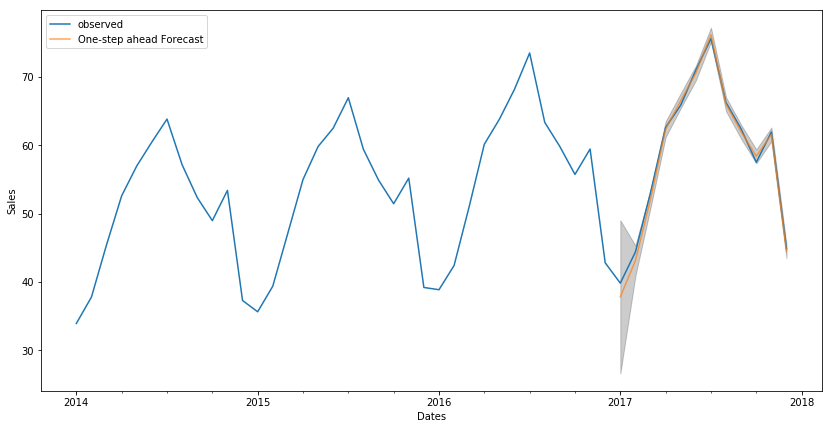

In [155]:
## Validating FOrecast
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7,
                        figsize = (14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color = 'k', alpha=.2)
ax.set_xlabel('Dates')
ax.set_ylabel('Sales')
plt.legend()

In [156]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse =  ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.73


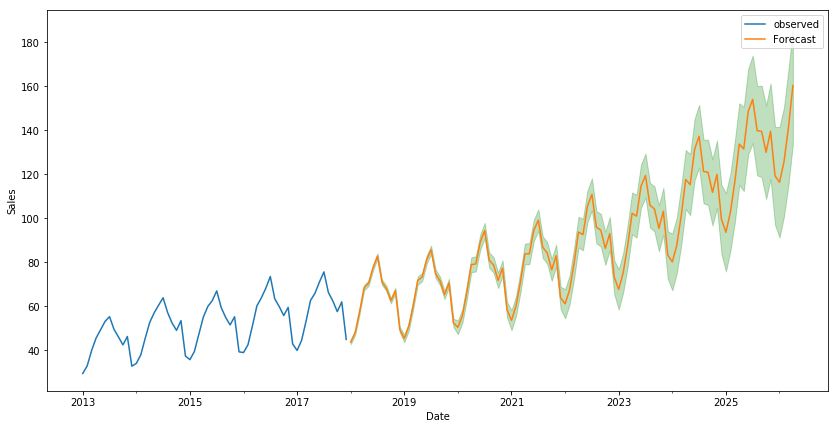

In [163]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [170]:
out_df_lgb = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': sub_preds.astype(np.int32)})
out_df_xgb = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': y_test.astype(np.int32)})
out_df_combined = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': ((sub_preds + y_test + 4)/2.).astype(np.int32)})
out_df_combined_25_75 = pd.DataFrame({'id': subs.id.astype(np.int32), 'sales': ((sub_preds *.25 + y_test *.75 + 4)).astype(np.int32)})

# Keras Embeddings

In [176]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, merge, Embedding, Input, Concatenate
from keras.models import Model as KerasModel
import keras.backend as K

In [179]:
cat_cols = ['Day', 'Dayofweek', 'Month', 'Week', 'item', 'store', 'weekofyear', 'Year']
for cols in cat_cols:
    df_raw[cols] = df_raw[cols].astype('category')
    df_test[cols] = df_test[cols].astype('category')

In [180]:
df_raw_cats = df_raw[cat_cols].copy()
df_test_cats = df_test[cat_cols].copy()

In [182]:
df_raw_cats.head()

,Day,Dayofweek,Month,Week,item,store,weekofyear,Year
0,1,1,1,1,1,1,1,2013
1,2,2,1,1,1,1,1,2013
2,3,3,1,1,1,1,1,2013
3,4,4,1,1,1,1,1,2013
4,5,5,1,1,1,1,1,2013


In [183]:
def split_features(X):
    X_list = []
    
    day = X[..., [0]]
    X_list.append(day)
    
    day_of_week = X[..., [1]]
    X_list.append(day_of_week)

    month = X[..., [2]]
    X_list.append(month)

    week_of_year = X[..., [6]]
    X_list.append(week_of_year)
    
    item = X[..., [4]]
    X_list.append(item)
    
    store = X[..., [5]]
    X_list.append(store)
    
    year = X[..., [7]]
    X_list.append(year)

    return X_list

In [198]:
def custom_smape(x, x_): # From the Public Kernel https://www.kaggle.com/rezas26/simple-keras-starter        
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))
    
class NN_with_EntityEmbedding():

    def __init__(self, X_train, y_train):
        
        super().__init__()
        
        self.epochs = 3
        self.__build_keras_model()
        self.fit(X_train, y_train)
    
    def preprocessing(self, X):
        
        X_list = split_features(X)
        return X_list

    def __build_keras_model(self):
        
        model_day = Input(shape=(1,))
        output_day = Embedding(31, 16, name='day_embedding')(model_day)
        output_day = Reshape(target_shape=(16,))(output_day)

        model_dow = Input(shape=(1,))
        output_dow = Embedding(7, 5, name='dow_embedding')(model_dow)
        output_dow = Reshape(target_shape=(5,))(output_dow)
        
        input_month = Input(shape=(1,))
        output_month = Embedding(12, 6, name='month_embedding')(input_month)
        output_month = Reshape(target_shape=(6,))(output_month)
        
        model_woy = Input(shape=(1,))
        output_woy = Embedding(52, 26, name='week_embedding')(model_woy)
        output_woy = Reshape(target_shape=(26,))(output_woy)
        
        model_item = Input(shape=(1,))
        output_item = Embedding(50, 26, name='item_embedding')(model_item)
        output_item = Reshape(target_shape=(26,))(output_item)
        
        model_store = Input(shape=(1,))
        output_store = Embedding(10, 6, name='store_embedding')(model_store)
        output_store = Reshape(target_shape=(6,))(output_store)
        
        model_year = Input(shape=(1,))
        output_year = Embedding(5, 3, name='year_embedding')(model_year)
        output_year = Reshape(target_shape=(3,))(output_year)

        input_model = [model_day, model_dow, input_month,
                       model_woy, model_item, model_store, model_year]

        output_embeddings = [output_day, output_dow, output_month,
                             output_woy, output_item, output_store, output_year]

        output_model = Concatenate()(output_embeddings)
        output_model = Dense(128, kernel_initializer="glorot_uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(32, kernel_initializer="glorot_uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(1)(output_model)

        self.model = KerasModel(inputs=input_model, outputs=output_model)
        self.model.compile(loss= custom_smape, optimizer='sgd')


    def fit(self, X_train, y_train):
        self.model.fit(self.preprocessing(X_train), y_train, epochs=self.epochs, batch_size=64)

    def guess(self, features):
        features = self.preprocessing(features)
        result = self.model.predict(features).flatten()
        return result

In [200]:
nn = NN_with_EntityEmbedding(df_raw_cats.values, original_target)

Epoch 1/3


InvalidArgumentError: indices[31,0] = 52 is not in [0, 52)
	 [[Node: week_embedding_6/embedding_lookup = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training_1/SGD/Assign_7"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](week_embedding_6/embeddings/read, week_embedding_6/Cast, training_1/SGD/gradients/week_embedding_6/embedding_lookup_grad/concat/axis)]]